In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.signal import convolve2d
from os import listdir, remove, system
import pickle

delete all files from frames folder

In [2]:
for fname in listdir('frames'):
    remove(f'frames/{fname}')

In [3]:
def makeVid():
    with open('mkvid.txt') as f:
        command = f.read()
    system(command)

Convenience imshow wrapper

In [4]:
def show(*args, **kwargs):
    if 'origin' not in kwargs:
        kwargs['origin'] = 'lower'
    
    # Call imshow with modified arguments
    plt.imshow(*args, **kwargs)
    plt.show()

In [5]:
filename = 'firespreaddata/firstarrival.txt'

Load the data

(380, 340)


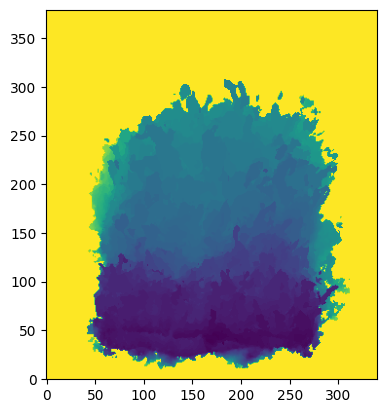

In [6]:
firstArrivalTime = np.loadtxt(filename)# np.transpose(np.loadtxt(filename))
# subtract the minimum time to get the time since the first frame
firstArrivalTime = firstArrivalTime - np.min(firstArrivalTime)
# flip the y-axis
firstArrivalTime = np.flip(firstArrivalTime, axis=0)
# print(set(list(firstArrivalTime.flat)))
# print(firstArrivalTime)
print(firstArrivalTime.shape)
show(firstArrivalTime)

In [7]:
def get_spread_mask(timestamps):
    spread_mask = np.zeros((len(timestamps), *firstArrivalTime.shape), dtype=bool)
    for i, timestamp in enumerate(timestamps):
        spread_mask[i, :] = firstArrivalTime <= timestamp
    return spread_mask

Get the spread mask for each time step from 5 to 100

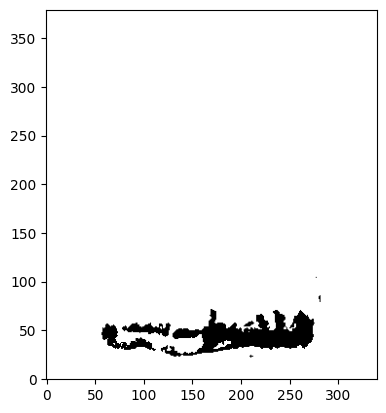

In [8]:
start = 5
timestamps = np.arange(start, 101)
spread_masks = get_spread_mask(timestamps)
show(spread_masks[0], cmap='binary')

In [9]:
# Create a video of the fire spread
# for i, (t, mask) in enumerate(zip(timestamps, spread_masks)):
#     plt.clf()
#     plt.imshow(mask * firstArrivalTime + 100 * np.logical_not(mask), vmin=0, vmax=np.max(firstArrivalTime))
#     plt.title(f"Fire spread at {t}s")
#     plt.tight_layout()
#     # plt.show()
#     plt.savefig(f'frames/{i:03}.png')
# # make video using command in mkvid.txt
# makeVid()
# exit()

use convolution to get the edge of the fire at each time step

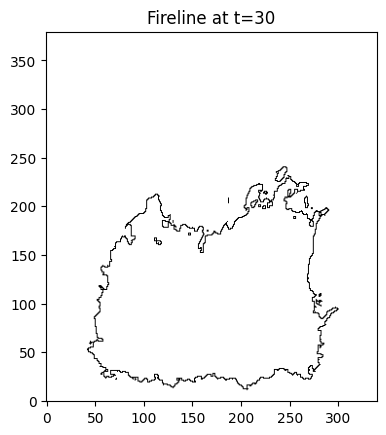

In [10]:
kernel = np.array([[1, 1, 1],
                   [1, 0, 1],
                   [1, 1, 1]])
edges = np.zeros_like(spread_masks)
for i, (t, spread_mask) in enumerate(zip(timestamps, spread_masks)):
    edges[i] = (convolve2d(spread_mask, kernel, mode='same', boundary='fill', fillvalue=0) != 8) & spread_mask
# plt.clf()
t = 30
plt.title(f'Fireline at t={t}')
show(edges[t], cmap='binary')
# plt.show()

get first ignition area

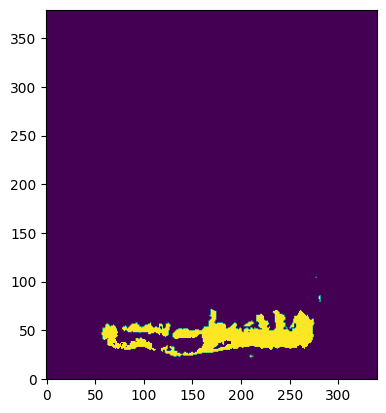

In [11]:
first_ignition = np.argwhere(firstArrivalTime <= start)
test = firstArrivalTime <= start
# print(first_ignition)
show(test)

centroid of first ignition area

In [12]:
first_ignition_centroid = np.mean(first_ignition, axis=0)
print(first_ignition_centroid)

[ 44.8669373  183.56517817]


get distance from centroid to all points

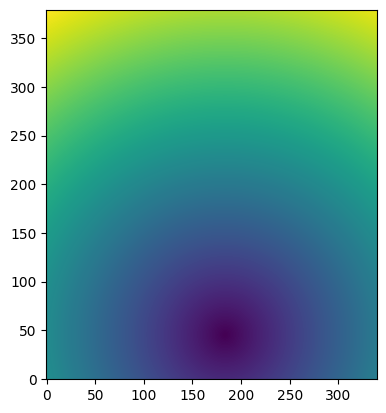

In [13]:
distances = np.zeros_like(firstArrivalTime)
for x in range(firstArrivalTime.shape[0]):
    for y in range(firstArrivalTime.shape[1]):
        distances[x,y] = np.sqrt((x - first_ignition_centroid[0])**2 + \
            (y - first_ignition_centroid[1])**2)
show(distances)

get y distance from centroid

In [14]:
height = np.zeros((len(timestamps), firstArrivalTime.shape[1]))
for i, (t, spread_mask, edge) in enumerate(zip(timestamps, spread_masks, edges)):
    for j in range(firstArrivalTime.shape[1]):
        if np.sum(edge[:, j]) == 0:
            height[i, j] = first_ignition_centroid[0]
        else:
            height[i, j] = np.max(np.argwhere(edge[:, j])[:, 0])
# height -= first_ignition_centroid[0]
# plt.plot(height[30])
# show(spread_masks[30], cmap='binary')

plot height for each time step

In [15]:
# ts = timestamps - start
# for t in ts:
#     plt.clf()
#     # ensure that the y-axis is the same for all frames
#     plt.ylim(0, firstArrivalTime.shape[0])
#     plt.plot(height[t])#, label=f't={t}')
#     plt.legend([f"t={t}"])
#     plt.imshow(spread_masks[t], cmap='binary', alpha=0.5, origin='lower')
#     plt.savefig(f'frames/{t:03}.png')
# makeVid()

In [16]:
height -= first_ignition_centroid[0]
x = np.arange(height.shape[1])
spread = [(x, y) for y in height]

In [17]:
with open('spread.pkl', 'wb') as f:
    pickle.dump(spread, f)

Create video

In [18]:
# plot the spread at each time step
# for i, spread in enumerate(spread):
#     plt.clf()
#     plt.scatter(spread[0], spread[1], s=1)
#     plt.xlim(-np.pi, np.pi)
#     plt.ylim(0, np.max(distances))
#     plt.title(f"Fire spread at {i}s")
#     plt.tight_layout()
#     plt.savefig(f'frames/{i:03}.png')